In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy.special import gamma
from scipy.optimize import fsolve
from tqdm import tqdm
from bokeh.layouts import gridplot
from bokeh.models import Range1d
from bokeh.plotting import figure, show

# Constant Infectivity Sims

In [167]:
n =50
m = 1
Q_unsorted = np.random.exponential(1,n)
Q = np.sort(Q_unsorted)
E = [2]*(n+m)
I = [5]*(n+m)

lmb =0.3
T = 5
D = 7
B = 2

30
12


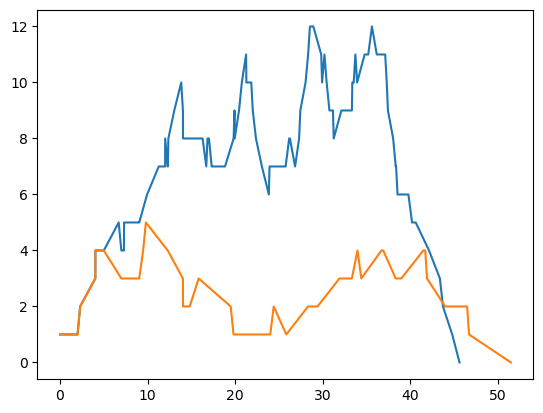

In [176]:
R = SEIRSelke_constant_reduction(n,m,Q,E,I,lmb,T,D,1)
print(R[-1][-1])
plt.plot(R[0],np.array(R[2])+np.array(R[3]))
R = SEIRSelke_constant_reduction(n,m,Q,E,I,lmb,T,19,3)
print(R[-1][-1])
plt.plot(R[0],np.array(R[2])+np.array(R[3]))

In [32]:
def SIRSelke_constant_threshold_reduction(n,m,Q,I,lmb,K,D,B):    
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    I_v = [m]
    
    pulsed = False
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    active_tau = [np.inf]*(n+m)
    
    for k in infected_indices:
        active_tau[k] = I[k]
    

    next_event_tau = {"infection": (Q[0]-A)/((lmb/n)*len(infected_indices)),
                      "recovery": min(active_tau),
                      "start intervention": np.inf,
                      "end intervention": np.inf}
    next_event_i = {"infection": m,
                    "recovery": active_tau.index(next_event_tau["recovery"])}
    
    
    
    effective_lmb = lmb

    
    
    
    while len(infected_indices)>0:
        dt = min(next_event_tau.values())
        active_tau = [tau-dt for tau in active_tau] 
        A+= (effective_lmb/n)*dt*len(infected_indices)
        t+=dt
        next_event_type = [i for i in next_event_tau.keys() if next_event_tau[i] == dt][0]

        if next_event_type ==  "start intervention":
            #print("pulse")
            effective_lmb = lmb/B
            next_event_tau["start intervention"] = np.inf
            pulsed = True

            
        elif next_event_type ==  "end intervention":
            #print("unpulse")
            effective_lmb = lmb
            next_event_tau["end intervention"] = np.inf
 
        
        elif next_event_type ==  "recovery":
            #print("Recovery")
            t_recov[next_event_i["recovery"]] = t
            recovered_indices.append(next_event_i["recovery"])
            infected_indices.remove(next_event_i["recovery"])
            active_tau[next_event_i["recovery"]] = np.inf

            
        
            
        elif next_event_type ==  "infection":
            #print("Infection")     
            t_inf[next_event_i["infection"]] = t
            infected_indices.append(next_event_i["infection"])
            active_tau[next_event_i["infection"]]  = I[next_event_i["infection"]]
            next_event_i["infection"] += 1
            if next_event_i["infection"]==n:
                next_event_tau["infection"]= np.inf
            
            
        
        if next_event_tau["infection"] <np.inf and len(infected_indices)!=0:
                next_event_tau["infection"] = (Q[next_event_i["infection"]-m]-A)/((effective_lmb/n)*len(infected_indices))
        next_event_tau["recovery"] = min(active_tau)
        next_event_i["recovery"] = active_tau.index(next_event_tau["recovery"])
        next_event_tau["end intervention"] = next_event_tau["end intervention"] -dt
        if len(infected_indices)+len(recovered_indices) == K and not pulsed:
            next_event_tau["end intervention"] = D
            next_event_tau["start intervention"] = 0
        

                
        t_v.append(t)
        A_v.append(A)
        I_v.append(len(infected_indices))
        
        #if A_prev>A:
        #    print("A =",A) 
        #print(active_tau)
        #print("")

        ##input("t="+str(t)+"\n")

    return(t_v,A_v,I_v,t_inf,t_recov,recovered_indices)
            


            

In [84]:
def SEIRSelke_constant_reduction(n,m,Q,E,I,lmb,T,D,B):    
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    I_v = [0]
    E_v = [m]
    
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    exposed_indices = [k for k in range(m)]
    infected_indices = []
    recovered_indices = []
    
    active_exposed_tau = [np.inf]*(n+m)
    active_tau = [np.inf]*(n+m)
    
    for k in exposed_indices:
        active_exposed_tau[k] = E[k]
    

    next_event_tau = {"exposure":np.inf,
                      "infection":min(active_exposed_tau),
                      "recovery": min(active_tau),
                      "start intervention": T,
                      "end intervention": T+D}
    next_event_i = {"exposure": m,
                    "infection":active_exposed_tau.index(next_event_tau["infection"]),
                    "recovery": active_tau.index(next_event_tau["recovery"])}
    
    
    
    effective_lmb = lmb

    
    
    
    while len(exposed_indices)+len(infected_indices)>0:
       
        dt = min(next_event_tau.values())
        
        active_tau = [tau-dt for tau in active_tau] 
        active_exposed_tau = [tau-dt for tau in active_exposed_tau] 
        
        A+= (effective_lmb/n)*dt*len(infected_indices)
        t+=dt
        next_event_type = [i for i in next_event_tau.keys() if next_event_tau[i] == dt][0]

        if next_event_type ==  "start intervention":
            #print("pulse")
            effective_lmb = lmb/B
            next_event_tau["start intervention"] = np.inf

            
        elif next_event_type ==  "end intervention":
            #print("unpulse")
            effective_lmb = lmb
            next_event_tau["end intervention"] = np.inf
 
        elif next_event_type == "exposure":
            #print("Exposure")
            exposed_indices.append(next_event_i["exposure"])
            susceptible_indices.remove(next_event_i["exposure"])
            active_exposed_tau[next_event_i["exposure"]]  = I[next_event_i["exposure"]]
            next_event_i["exposure"] += 1
            if len(susceptible_indices)==0:
                next_event_tau["exposure"]= np.inf
        
        elif next_event_type ==  "infection":
            #print("Infection")     
            t_inf[next_event_i["infection"]] = t
            infected_indices.append(next_event_i["infection"])
            exposed_indices.remove(next_event_i["infection"])
            active_tau[next_event_i["infection"]]  = I[next_event_i["infection"]]
            active_exposed_tau[next_event_i["infection"]] = np.inf
            if len(exposed_indices)==0:
                next_event_tau["infection"]= np.inf    
        
        elif next_event_type ==  "recovery":
            #print("Recovery")
            t_recov[next_event_i["recovery"]] = t
            recovered_indices.append(next_event_i["recovery"])
            infected_indices.remove(next_event_i["recovery"])
            active_tau[next_event_i["recovery"]] = np.inf

            
        
            
       
            
            
        
        if len(susceptible_indices)!=0 and len(infected_indices)!=0:
                next_event_tau["exposure"] = (Q[next_event_i["exposure"]-m]-A)/((effective_lmb/n)*len(infected_indices))
                
        next_event_tau["infection"] = min(active_exposed_tau)
        next_event_i["infection"] = active_exposed_tau.index(next_event_tau["infection"])                
        next_event_tau["recovery"] = min(active_tau)
        next_event_i["recovery"] = active_tau.index(next_event_tau["recovery"])        
        next_event_tau["end intervention"] = next_event_tau["end intervention"] -dt
        next_event_tau["start intervention"] = next_event_tau["start intervention"] -dt
                
        t_v.append(t)
        A_v.append(A)
        I_v.append(len(infected_indices))
        E_v.append(len(exposed_indices))
        
        #if A_prev>A:
        #    print("A =",A) 
        #print(active_tau)
        #print("")

        #print("t=",t,"\n")

    return(t_v,A_v,I_v,E_v,t_inf,t_recov,recovered_indices)

In [ ]:
def SIRSelke_constant_reduction(n,m,Q,I,lmb,T,D,B):    
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    I_v = [m]
    
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    active_tau = [np.inf]*(n+m)
    
    for k in infected_indices:
        active_tau[k] = I[k]
    

    next_event_tau = {"infection": (Q[0]-A)/((lmb/n)*len(infected_indices)),
                      "recovery": min(active_tau),
                      "start intervention": T,
                      "end intervention": T+D}
    next_event_i = {"infection": m,
                    "recovery": active_tau.index(next_event_tau["recovery"])}
    
    
    
    effective_lmb = lmb

    
    
    
    while len(infected_indices)>0:
        
        dt = min(next_event_tau.values())
        
        active_tau = [tau-dt for tau in active_tau] 
        A+= (effective_lmb/n)*dt*len(infected_indices)
        t+=dt
        next_event_type = [i for i in next_event_tau.keys() if next_event_tau[i] == dt][0]

        if next_event_type ==  "start intervention":
            #print("pulse")
            effective_lmb = lmb/B
            next_event_tau["start intervention"] = np.inf

            
        elif next_event_type ==  "end intervention":
            #print("unpulse")
            effective_lmb = lmb
            next_event_tau["end intervention"] = np.inf
 
        
        elif next_event_type ==  "recovery":
            #print("Recovery")
            t_recov[next_event_i["recovery"]] = t
            recovered_indices.append(next_event_i["recovery"])
            infected_indices.remove(next_event_i["recovery"])
            active_tau[next_event_i["recovery"]] = np.inf

            
        
            
        elif next_event_type ==  "infection":
            #print("Infection")     
            t_inf[next_event_i["infection"]] = t
            infected_indices.append(next_event_i["infection"])
            active_tau[next_event_i["infection"]]  = I[next_event_i["infection"]]
            next_event_i["infection"] += 1
            if next_event_i["infection"]==n:
                next_event_tau["infection"]= np.inf
            
            
        
        if next_event_tau["infection"] <np.inf and len(infected_indices)!=0:
                next_event_tau["infection"] = (Q[next_event_i["infection"]-m]-A)/((effective_lmb/n)*len(infected_indices))
        next_event_tau["recovery"] = min(active_tau)
        next_event_i["recovery"] = active_tau.index(next_event_tau["recovery"])        
        next_event_tau["end intervention"] = next_event_tau["end intervention"] -dt
        next_event_tau["start intervention"] = next_event_tau["start intervention"] -dt
                
        t_v.append(t)
        A_v.append(A)
        I_v.append(len(infected_indices))
        
        #if A_prev>A:
        #    print("A =",A) 
        #print(active_tau)
        #print("")

        #print("t=",t,"\n")

    return(t_v,A_v,I_v,t_inf,t_recov,recovered_indices)
            


            

In [ ]:
def SIRSelke_constant_pulse(n,m,Q,I,lmb,T,P,p):
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    I_v = [m]
    
    
    t_inf = [0]*(n+m)
    t_recov = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    active_tau = [np.inf]*(n+m)
    
    for k in infected_indices:
        active_tau[k] = I[k]
    

    next_event_tau = {"infection": (Q[0]-A)/((lmb/n)*len(infected_indices)),
                      "recovery": min(active_tau),
                      "start intervention": T}
    next_event_i = {"infection": m,
                    "recovery": active_tau.index(next_event_tau["recovery"])}
    
    
    
    effective_lmb = lmb

    
    
    
    while len(infected_indices)>0:
        
        dt = min(next_event_tau.values())
        
        active_tau = [tau-dt for tau in active_tau] 
        A+= (effective_lmb/n)*dt*len(infected_indices)
        t+=dt
        next_event_type = [i for i in next_event_tau.keys() if next_event_tau[i] == dt][0]

        if next_event_type ==  "start intervention":
            #print("pulse")
            for i in infected_indices:
                if P[i]<p:
                    indices_spotted.append(i)
                    
                    active_tau[i] = np.inf
                    
            indices_spotted = []       
            for i in indices_spotted:
                recovered_indices.append(i)
                infected_indices.remove(i)
                t_recov[i] = t
            next_event_tau["start intervention"] = np.inf

            
 
        
        elif next_event_type ==  "recovery":
            #print("Recovery")
            t_recov[next_event_i["recovery"]] = t
            recovered_indices.append(next_event_i["recovery"])
            infected_indices.remove(next_event_i["recovery"])
            active_tau[next_event_i["recovery"]] = np.inf

            
        
            
        elif next_event_type ==  "infection":
            #print("Infection")     
            t_inf[next_event_i["infection"]] = t
            infected_indices.append(next_event_i["infection"])
            active_tau[next_event_i["infection"]]  = I[next_event_i["infection"]]
            next_event_i["infection"] += 1
            if next_event_i["infection"]==n+1:
                next_event_tau["infection"]= np.inf
            
            
        
        if next_event_tau["infection"] <np.inf and len(infected_indices)!=0:
                next_event_tau["infection"] = (Q[next_event_i["infection"]-m]-A)/((effective_lmb/n)*len(infected_indices))
        next_event_tau["recovery"] = min(active_tau)
        next_event_i["recovery"] = active_tau.index(next_event_tau["recovery"])    
        next_event_tau["start intervention"] = next_event_tau["start intervention"] -dt
                
        t_v.append(t)
        A_v.append(A)
        I_v.append(len(infected_indices))
        
        #if A_prev>A:
        #    print("A =",A) 
        #print(active_tau)
        #print("")

        #print("t=",t,"\n")

    return(t_v,A_v,I_v,t_inf,t_recov,recovered_indices)
            
            

# Weibull Infectivity Sim

In [ ]:
def SIRSelke_Weibull(n,m,Q,lmb,a,b):
    A = 0 
    t = 0
    
    t_v = [0]
    A_v = [0]
    I_v = [m]
    
    
    t_inf = [0]*(n+m)

    susceptible_indices = [k for k in range(m,n+m)]
    infected_indices = [k for k in range(m)]
    recovered_indices = []
    
    
    for k in infected_indices:
        active_tau[k] = I[k]
    
    f = lambda x: Q[0] - (lmb/n)*sum([1-np.exp(-((x-t_inf[k])/b)**a) for k in infected_indices])
    if Q[0] - (lmb/n)*sum([1 for k in infected_indices])>0.001:
        return(t_v,A_v,I_v,t_inf,infected_indices)
    else:
        next_infection_time = fsolve(f,t+2*b*((a-1)/a)**(1/a))[0]
    
    next_event_tau = {"infection": next_infection_time}
    next_event_i = {"infection": m}    
    
    
    while len(infected_indices)>0:
        
        dt = min(next_event_tau.values())
        
        A+= (lmb/n)*sum([np.exp(-((t-t_inf[k])/b)**a)-np.exp(-((t+dt-t_inf[k])/b)**a) for k in infected_indices]) #force up until previous event
        t+=dt
        next_event_type = [i for i in next_event_tau.keys() if next_event_tau[i] == dt][0]

        if next_event_type ==  "infection":
            #print("Infection")     
            t_inf[next_event_i["infection"]] = t
            infected_indices.append(next_event_i["infection"])
            susceptible_indices.remove(next_event_i["infection"])
            next_event_i["infection"] += 1
            if len(susceptible_indices)==0:
                next_event_tau["infection"]= np.inf
                return(t_v,A_v,I_v,t_inf,infected_indices)
            
            
        
        if next_event_tau["infection"] <np.inf and len(infected_indices)!=0:
            f = lambda x: Q[next_event_i["infection"]-m] - (lmb/n)*sum([np.exp(-((t-t_inf[k])/b)**a)-np.exp(-((x-t_inf[k])/b)**a) for k in infected_indices]) -A
            if Q[next_event_i["infection"]-m] - (lmb/n)*sum([np.exp(-((t-t_inf[k])/b)**a) for k in infected_indices]) -A>0.001:
                
                return(t_v,A_v,I_v,t_inf,infected_indices)
                
            else:
                next_infection_time = fsolve(f,t+2*b*((a-1)/a)**(1/a))[0]
                next_event_tau = {"infection": next_infection_time}
                
                         
                
        t_v.append(t)
        A_v.append(A)
        I_v.append(len(infected_indices))
        
        #if A_prev>A:
        #    print("A =",A) 
        #print(active_tau)
        #print("")

        #print("t=",t,"\n")

    return(t_v,A_v,I_v,t_inf,infected_indices)